## Imports

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
import re
from nltk.stem.porter import PorterStemmer
from pprint import pprint
from nltk.corpus import stopwords
from collections import Counter
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertModel
from torch.nn.functional import softmax
import torch
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/axelzhao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# df = pd.read_csv("tweets.csv")
df = pd.read_csv("../data/tweets.csv")
df.head(1)

,Unnamed: 0,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,0,Tushar Gupta at DevFest Raipur.,Is this the end of Twitter threads?\n#AI #Chat...,India,•Experiencing Life💬 && Tech🥑 •Learning about💻:...,2021-10-05 05:05:55+00:00,230.0,438.0,1567,FALSE,2022-12-20 13:29:08+00:00,"['AI', 'ChatGPT']",Twitter for Android


## NLP Cleaning

In [3]:
# Remove Spam
df = df[(df['text'].str.contains('MidJour') == False) & (df['text'].str.contains('Giveaway') == False)]

def preprocessing(text):
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # introduce stemmer and stop words
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # cleaning and tokennize
    cleaned_tokens = []
    
    # tokenize, lowercase, remove stop words, and stemming
    for token in word_tokenize(text):
        token = token.lower()
        if token not in stop_words and token.isalnum():
            cleaned_tokens.append(ps.stem(token))
            
    return ' '.join(cleaned_tokens)

# create a new column for preprocessed text
df["preprocessed_text"] = df.text.apply(preprocessing)
df.head(2)

,Unnamed: 0,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,preprocessed_text
0,0,Tushar Gupta at DevFest Raipur.,Is this the end of Twitter threads?\n#AI #Chat...,India,•Experiencing Life💬 && Tech🥑 •Learning about💻:...,2021-10-05 05:05:55+00:00,230.0,438.0,1567,FALSE,2022-12-20 13:29:08+00:00,"['AI', 'ChatGPT']",Twitter for Android,end twitter thread ai chatgpt openai
1,1,PharmaTechnologyTrends,ChatGPT is a truly mind-blowing tool and playi...,"Frankfurt am Main, Deutschland",Latest News and Trends in Pharmaceutical Industry,2022-11-06 21:03:59+00:00,264.0,4333.0,24,FALSE,2022-12-20 13:28:50+00:00,NaN,EveryoneSocial,chatgpt truli tool play around definit send ra...


By observing the result in clustering, we found there are some spam messages, and all of them contains words "MidJour" or "Giveaway". After removing those rows, there are 400+ rows reduced.

The cleaning function above involves various common techniques in text preprocessing in NLP. Below is a detailed explanation of these steps:
- Use `Rege`x to remove URLs ensures irrelevant information has been excluded since URLs do not contain sentiment information that is useful for this research.
- Use `word_tokenize` to tokenize texts into individual tokens.
- Use lowercase, remove punctuation, remove stop words from `stopwords`, and stemming from `PorterStemmer` to ensure tokenized text free from redundancy, and standardize words to their root form.

In [4]:
df.shape

(38632, 14)

## Most Common Tokens/Trigrams and Counts

In [5]:
# extract tokens into a list of lists
tokens = []
for text in df.preprocessed_text:
    tokens.extend(text.split())

In [6]:
# count the tokens and print the most common ones
token_counts = Counter(tokens)
print('20 most common tokens and counts:')
pprint(token_counts.most_common(20))

20 most common tokens and counts:
[('chatgpt', 44586),
 ('ai', 11117),
 ('openai', 7409),
 ('use', 4846),
 ('ask', 4340),
 ('write', 3518),
 ('like', 3069),
 ('answer', 2252),
 ('question', 2083),
 ('make', 2016),
 ('get', 1997),
 ('gener', 1988),
 ('new', 1988),
 ('think', 1936),
 ('tri', 1919),
 ('code', 1886),
 ('one', 1812),
 ('googl', 1788),
 ('know', 1741),
 ('time', 1720)]


In [7]:
# count the trigrams and print the most common ones
tri_counts = Counter(ngrams(tokens, 3))
print('The most prevalent trigram and count:')
pprint(tri_counts.most_common(20))

The most prevalent trigram and count:
[(('ask', 'chatgpt', 'write'), 504),
 (('chatgpt', 'ask', 'chatgpt'), 320),
 (('chatgpt', 'openai', 'chatgpt'), 229),
 (('ai', 'chatgpt', 'openai'), 182),
 (('chatgpt', 'ai', 'openai'), 168),
 (('larg', 'languag', 'model'), 147),
 (('1', 'million', 'user'), 136),
 (('openai', 'chatgpt', 'chatgpt'), 130),
 (('chatgpt', 'ai', 'chatgpt'), 128),
 (('chatgpt', 'openai', 'ai'), 115),
 (('ask', 'openai', 'chatgpt'), 111),
 (('peopl', 'talk', 'chatgpt'), 111),
 (('talk', 'chatgpt', 'ai'), 110),
 (('play', 'around', 'chatgpt'), 109),
 (('openai', 'chatgpt', 'openai'), 109),
 (('use', 'chatgpt', 'write'), 107),
 (('3', 'tax', 'liquid'), 102),
 (('tax', 'liquid', 'lock'), 102),
 (('super', 'bullish', 'one'), 102),
 (('bullish', 'one', 'lot'), 102)]


This section identified the top 20 most common words and trigrams from the user reveiw texts. It used `Counter` to count the token occurrences and generate most common results, and used `ngrams` to capture local context in text. The above methhods provides a simple and general understanding of what the corpus is about, as well as patterns and themes in the dataset.
<br>
<br>
However, the frequency of a word does not represent the importance of that word for user sentiment expression. For methods focusing on sentiment analysis will be elaborated in the following sections

## Equipping Sentiment Labels with `VADER`

In [8]:
# Reference for categorizing compound score:
# https://towardsdatascience.com/social-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8

# VADER sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# function to generate sentiment labels based on preprocessed_text column
def get_sentiment_labels(preprocessed_text):
    # calculate setiment scores, from scr, extract compound score
    scores = vader.polarity_scores(preprocessed_text)
    compound = scores["compound"]
    
    # 1: positive
    # -1: negative
    # 0: neutral
    if compound > 0.05:
        return 1
    elif compound < -0.05:
        return -1
    else:
        return 0

# create a new column for vader sentiment labels
df["label_vader"] = df.preprocessed_text.apply(get_sentiment_labels)

Text(0.5, 1.0, 'Distribution of label_vader Sentiment Values')

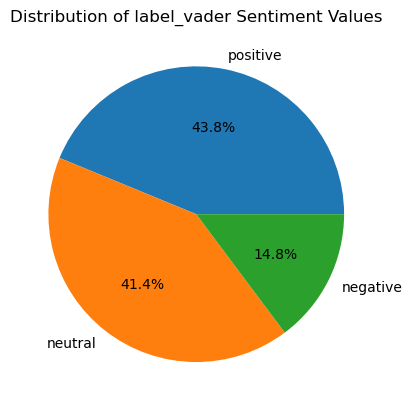

In [9]:
label_value_counts = df.label_vader.value_counts()

plt.pie(label_value_counts, 
        labels = label_value_counts.index.map({1: 'positive', 0: 'neutral', -1: 'negative'}), 
        autopct= "%1.1f%%")

plt.title('Distribution of label_vader Sentiment Values')

Reference for VADER introduction: 
<br>
https://github.com/cjhutto/vaderSentiment
<br>
<br>
This section used `SentimentIntensityAnalyzer` from `VADER` to determine the sentiment of user review text. In specific, it examines the compound score (> 0.05: positive, < -0.05: negative, in-between: neutral) to set thresholds in categorizing sentiment labels as 1, -1, 0 respectively.
<br>
<br>
In this research, we conducted a series of sentiment analysis based on the user review from social media. This is align with the nature of `VADER`: "a rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media." (vaderSentiment). In addition, the choice of categorizing sentiment based on 0.05 and -0.05 compund score is a commonly used practice in sentiment analysis.
<br>
<br>
The limitation for this method is the value of thresholds in categorizing sentiment may not be an universal golden rule, hence adjust these thresholds accordingly with dataset might be necessary. Furthermore, using only 1, -1, and 0 for positive, negative, and neutral may leave out more detailed information about sentiments.

## Top `TF-IDF` Weighted Vectors by Label

In [10]:
# split data to 80% training and 20% validation
dfT, dfV = train_test_split(df, test_size = 0.2, random_state=42)

# Use the tf-idf vectorizer to convert all texts into weighted vectors 
# Only keep words that appear at least 5 times
vectorizer = TfidfVectorizer(min_df = 5)
train_vectors = vectorizer.fit_transform(dfT.text)
test_vectors = vectorizer.transform(dfV.text)

# get all the tokens
all_token = np.array(vectorizer.get_feature_names_out())

result = {}

# for each class c, get top 10 token and its weight
for l in dfT.label_vader.unique():
    
    # match label, then get vectorizer
    l_df = dfT[dfT.label_vader == l]
    l_vectors = vectorizer.transform(l_df.text)
    
    # get highest values, get sort
    weight = l_vectors.max(axis=0).toarray()[0]
    sort = np.argsort(weight)[::-1]
    
    # get top 10 that matches the label
    top10 = all_token[sort][:10]
    top10_val = weight[sort][:10]
    result[l] = dict(zip(top10, top10_val))

result

{0: {'chatgpt': 1.0,
  'something': 0.9979334205762714,
  'omfg': 0.9945575215523764,
  'decode': 0.9945575215523764,
  'threadreaderapp': 0.9945575215523764,
  'stunned': 0.9938016495519045,
  'monetize': 0.993565661734726,
  'rocks': 0.9933526638326333,
  'neither': 0.9931576039040295,
  'nope': 0.9931576039040295},
 1: {'chatgpt': 1.0,
  'yep': 0.9964108049291959,
  'well': 0.9784944064382534,
  'lmfao': 0.9731856994557782,
  'recommends': 0.9702063034325852,
  'iex_ec': 0.9675313559169861,
  'enjoying': 0.9641867546953353,
  'sweet': 0.963487456440415,
  'season': 0.9599143048187637,
  'haha': 0.9561684804315579},
 -1: {'damn': 0.9892124710666057,
  'lame': 0.9715651009646014,
  'gotcha': 0.9715651009646014,
  'worthless': 0.9715651009646014,
  'strike': 0.9702063034325852,
  'fuck': 0.965315418907409,
  'doomed': 0.9649274381295324,
  'disappointed': 0.963487456440415,
  'fail': 0.9599143048187637,
  'obsessed': 0.9591427419070189}}

Term frequency-inverse document frequency (TF-IDF) measures how important a word is to a document considering the whole corpus (or collection of documents). It focused on examining how relevant a word is in a single document rather than the frequency of a word that appears in the corpus.
<br>
<br>
TF-IDF is a standard word embedding technique that transforms words into weighted vectors to capture the crucialness of the word. In this case, using the original "text" column instead of "preprocessed_text" produces a more 
<br>
<br>
However, the limitation of TF-IDF is it only examines word itself, which may result in the model not capturing the semantic relationship within the context. The following sections will use more advanced models to tackle semantic meanings inside the sentiments.

# Word Embeddings & Modeling with TF-IDF

In [11]:
# train and validation set for knn
Xt = train_vectors
yt = dfT.label_vader
Xv = test_vectors
yv = dfV.label_vader

# knn model with 10 neighbors and cosine similarity 
knn = KNeighborsClassifier(n_neighbors = 10, metric = "cosine")
knn.fit(Xt, yt)

# predict label
yv_hat = knn.predict(Xv)

# micro and macro F1
microF1 = f1_score(yv, yv_hat, average = "micro")
macroF1 = f1_score(yv, yv_hat, average = "macro")

microF1, macroF1

(0.5969975410896855, 0.5284235320227347)

In [12]:
# classification report
print(classification_report(yv, yv_hat))

              precision    recall  f1-score   support

          -1       0.78      0.26      0.39      1086
           0       0.53      0.93      0.67      3274
           1       0.80      0.38      0.52      3367

    accuracy                           0.60      7727
   macro avg       0.70      0.52      0.53      7727
weighted avg       0.68      0.60      0.57      7727



# Sentence Embeddings & Modeling with `BERT`

In [13]:
# load BERT
model = SentenceTransformer("bert-base-nli-mean-tokens")

# sentence embedding
train_BERT = model.encode(dfT.preprocessed_text.tolist(), show_progress_bar=True)
test_BERT = model.encode(dfV.preprocessed_text.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/966 [00:00<?, ?it/s]

Batches:   0%|          | 0/242 [00:00<?, ?it/s]

In [14]:
# train and validation set for knn
Xt = train_BERT
yt = dfT.label_vader
Xv = test_BERT
yv = dfV.label_vader

# knn model with 10 neighbors and cosine similarity 
knn = KNeighborsClassifier(n_neighbors = 10, metric = "cosine")
knn.fit(Xt, yt)

# predict label
yv_hat = knn.predict(Xv)

# micro and macro F1
microF1 = f1_score(yv, yv_hat, average = "micro")
macroF1 = f1_score(yv, yv_hat, average = "macro")

microF1, macroF1

(0.7177429791639705, 0.687218304885985)

In [15]:
# classification report
print(classification_report(yv, yv_hat))

              precision    recall  f1-score   support

          -1       0.61      0.56      0.59      1086
           0       0.72      0.79      0.75      3274
           1       0.75      0.70      0.72      3367

    accuracy                           0.72      7727
   macro avg       0.69      0.68      0.69      7727
weighted avg       0.72      0.72      0.72      7727



This section used `Sentence-BERT` and `KNN classifier` to use the "preprocessed_text" column to predict label. Sentence-BERT transformer is commonly used for sentence embeddings by capturing samentic relathinthips across sentences. KNN classifier with `cosine similarity` is used to measure the angular difference between vectors.
<br>
<br>
whats good?
<br>
<br>
whats bad?